# Cleaned Jiang dataset exploration
## Importing necessary packages

In [3]:
%load_ext autoreload
%autoreload 2
from dataset_utils.torchtext_dataset import CommitMessageGenerationDataset
import Config
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating `torchtext.data.Dataset` and printing some information

In [5]:
config = Config()
train_ds_commit, val_ds_commit, test_ds_commit, fields_commit = \
       CommitMessageGenerationDataset.load_data(verbose=True, config=config)

Dataset sizes (number of sentence pairs):
train 22016
valid 2500
test 2510 

Max src sequence length in tokens: 512
Max trg sequence length in tokens: 80

Random (18046'th) training example:
src (diff): <s> mmm ġa ġ/ ġson ar ġ- ġserver ġ/ ġsrc ġ/ ġmain ġ/ ġweb app ġ/ ġwe b ġ- ġinf ġ/ ġdb ġ/ ġmigrate ġ/ ġ4 63 _ add _ admin ister _ issues _ perm ġ. ġr b ġ< nl > ġp pp ġb ġ/ ġson ar ġ- ġserver ġ/ ġsrc ġ/ ġmain ġ/ ġweb app ġ/ ġwe b ġ- ġinf ġ/ ġdb ġ/ ġmigrate ġ/ ġ4 63 _ add _ admin ister _ issues _ perm ġ. ġr b ġ< nl > ġ# ġ< nl > ġ# ġ< nl > ġ- ġ# ġson ar ġ3 ġ. ġ6 ġ< nl > ġ+ ġ# ġson ar q ube ġ4 ġ. ġ1 ġ< nl > ġ+ ġ# ġs on ar ġ- ġ24 47 ġ< nl > ġ# ġ< nl > ġclass ġadd admin ister iss ues per m ġ< ġactive record ġ: ġ: ġmigration ġ< nl > </s>
src (prev): <s> mmm ġa ġ/ ġson ar ġ- ġserver ġ/ ġsrc ġ/ ġmain ġ/ ġweb app ġ/ ġwe b ġ- ġinf ġ/ ġdb ġ/ ġmigrate ġ/ ġ4 63 _ add _ admin ister _ issues _ perm ġ. ġr b ġ< nl > ġ# ġ< nl > ġ# ġ< nl > ġ# ġson ar ġ3 ġ. ġ6 ġ< nl > ġ# ġ< nl > ġclass ġadd admin ister iss u

## Plotting frequencies of vocab of training part


### Helper functions

In [ ]:
def plot_frequency_dist(src_vocab, trg_vocab):
    def take_boundary(boundary):
        mask = np.logical_and(frequencies >= boundary[0], frequencies < boundary[1])
        return frequencies[mask]

    def get_mass_of_frequencies(boundary):
        boundaried_frequencies = take_boundary(boundary)
        return len(boundaried_frequencies) / len(frequencies)

    def get_mass_of_tokens(boundary):
        boundaried_frequencies = take_boundary(boundary)
        return boundaried_frequencies.sum() / frequencies.sum()

    def tokens_in_src_and_trg(boundary):
        tokens_inside_boundary = set([k for k, v in trg_vocab.freqs.items() if boundary[0] <= v < boundary[1]])
        src_tokens = set(t for t in src_vocab.freqs.keys())
        return tokens_inside_boundary & src_tokens, tokens_inside_boundary - src_tokens

    def print_examples_in_boundary(boundary, n):
        print()
        in_src, out_src = tokens_in_src_and_trg(boundary)
        in_src, out_src = list(in_src)[:n], list(out_src)[:n]
        print(f'{n} examples with frequency in [{boundary[0]}; {boundary[1]}) in src')
        print("\n".join(in_src))
        print(f'{n} examples with frequency in [{boundary[0]}; {boundary[1]}) out of src')
        print("\n".join(out_src))

    def print_most_common(n):
        print()
        print(f'{n} most common words')
        print('\n'.join([f'{k}    {v}' for k, v in trg_vocab.freqs.most_common(n)]))

    frequencies = np.array(list(trg_vocab.freqs.values()))
    max_frequency = np.max(frequencies)
    min_frequency = np.min(frequencies)

    cnt = Counter([el for el in frequencies])
    print(f'Max frequency: {max_frequency}')
    print(f'Min frequency: {min_frequency}')
    print(f'Mean frequency: {np.mean(frequencies)}')
    print(f'Std frequency: {np.std(frequencies)}')
    print(f'The most probable frequency: {cnt.most_common(1)[0][0]}, p = {round(cnt.most_common(1)[0][1] / len(frequencies), 2)}')
    print(f'Number of frequencies (trg_vocab size): {len(frequencies)}')
    print(f'Sum of frequencies (number of tokens in train dataset): {frequencies.sum()}')

    boundaries = [(min_frequency, max_frequency + 1),
                  (min_frequency, min_frequency + 1),
                  (min_frequency, min_frequency + 5),
                  (min_frequency, min_frequency + 15),
                  (min_frequency, min_frequency + 50),
                  (min_frequency + 2, min_frequency + 50),
                  (min_frequency + 5, min_frequency + 50),
                  (min_frequency + 10, min_frequency + 30),
                  (min_frequency + 50, max_frequency + 1),
                  (min_frequency + 499, max_frequency + 1),
                  (min_frequency + min(999, max_frequency - 100), max_frequency + 1),
                  (max_frequency - 10, max_frequency + 1)]
    f, axes = plt.subplots(int((len(boundaries) - 1) / 2) + 1, 2, figsize=(20, 20))
    for i, boundary in enumerate(boundaries):
        mass_freq = get_mass_of_frequencies(boundary)
        mass_tokens = get_mass_of_tokens(boundary)
        src_trg_tokens, _ = tokens_in_src_and_trg(boundary)
        in_src_tokens_ratio = len(src_trg_tokens) / len(take_boundary(boundary))
        label = f'boundary: [{boundary[0]}; {boundary[1]}), mass_of_freq: {round(mass_freq, 2)}, mass_of_tokens: {round(mass_tokens, 2)}, in_src_tokens_ratio: {round(in_src_tokens_ratio, 2)}'
        sns.distplot(take_boundary(boundary), ax=axes[int(i / 2), i % 2], axlabel=label)
    plt.show()
    print_examples_in_boundary((min_frequency, min_frequency + 1), n=5)
    print_examples_in_boundary((min_frequency + 499, max_frequency + 1), n=5)
    print_examples_in_boundary((min_frequency + 999, max_frequency + 1), n=5)
    print_most_common(n=5)

In [7]:
def analyze_vocabs(src_vocab, trg_vocab):
    print('Vocab information')
    print(f'Src size: {len(src_vocab)}')
    print(f'Trg size: {len(trg_vocab)}')
    plot_frequency_dist(src_vocab, trg_vocab)

### Plots

Vocab information
Src size: 14027
Trg size: 9900
Max frequency: 22016
Min frequency: 1
Mean frequency: 23.913719943422915
Std frequency: 348.68814887862317
The most probable frequency: 1, p = 0.32
Number of frequencies (trg_vocab size): 9898
Sum of frequencies (number of tokens in train dataset): 236698

5 examples with frequency in [1; 2) in src
ġhebrew
ġbelong
ances
ġautomation
ġgalaxy
5 examples with frequency in [1; 2) out of src
ġ980
shit
ġlame
ġunnecess
ġguests

5 examples with frequency in [500; 22017) in src
fix
m
ġin
fixed
ġ-
5 examples with frequency in [500; 22017) out of src


5 examples with frequency in [1000; 22017) in src
fix
ġin
ġ-
ġto
ġthe
5 examples with frequency in [1000; 22017) out of src


5 most common words
<s>    22016
</s>    22016
ġ.    10403
ġto    5502
ġ-    4877


C:\Users\sarid\anaconda3\envs\commit_message_generation\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\sarid\anaconda3\envs\commit_message_generation\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\sarid\anaconda3\envs\commit_message_generation\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\sarid\anaconda3\e

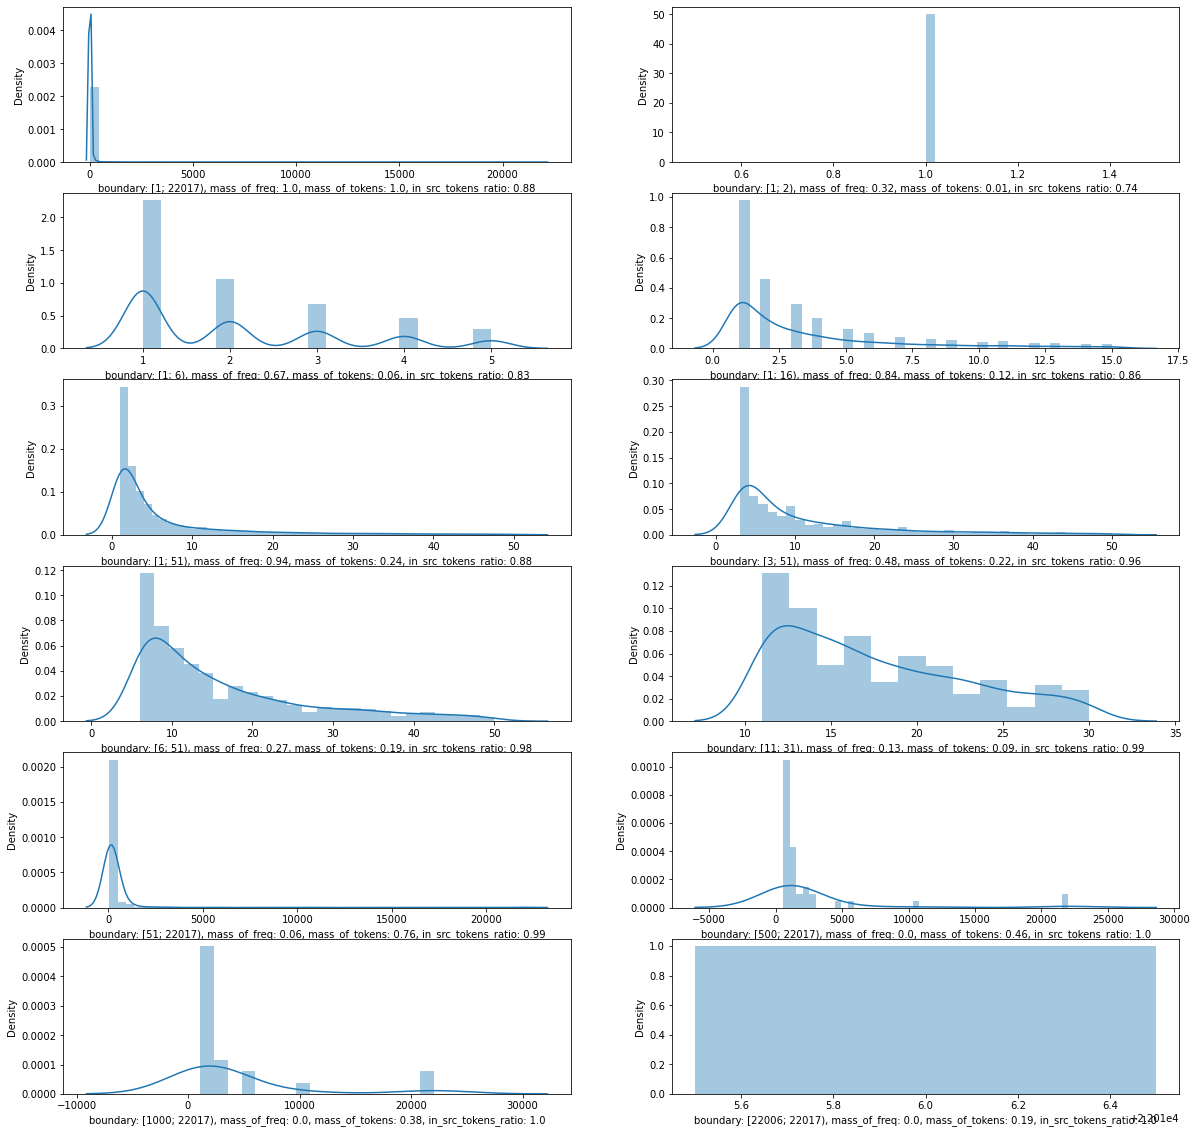

In [9]:
src_vocab = train_ds_commit.fields["src"].vocab
trg_vocab = train_ds_commit.fields["trg"].vocab
analyze_vocabs(src_vocab, trg_vocab)